# 0) Work Directory and setup

In [1]:
import os
# Obtiene el nuevo directorio actual después del cambio
new_directory = '/Users/jyoung/Doctorado/embryo_classification/'
os.chdir(new_directory)
print("New actual directory:", new_directory)

# Elimino warnings molestas
import warnings
warnings.filterwarnings("ignore")

New actual directory: /Users/jyoung/Doctorado/embryo_classification/


# 1) Libraries

In [2]:
# Data Manipulation and Visualization
import numpy as np                  # NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt     # Matplotlib for creating visualizations
from pathlib import Path            # Pathlib for working with file paths
import openpyxl                     # Openpyxl for reading and writing Excel files
import json                         # JSON for data serialization
from tqdm import tqdm               # tqdm for creating progress bars
from typing import Tuple, List, Union  # Typing for type hinting in function signatures

# Model Training and Evaluation
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold  # Hyperparameter tuning and cross-validation
from sklearn.tree import DecisionTreeClassifier  # DecisionTreeClassifier for tree-based models
from sklearn.ensemble import RandomForestClassifier  # RandomForestClassifier for ensemble learning
from sklearn.metrics import confusion_matrix, accuracy_score  # Metrics for model evaluation
from sklearn.svm import SVC          # Support Vector Classification
from sklearn.neural_network import MLPClassifier  # Multi-layer Perceptron classifier
import xgboost as xgb               # XGBoost for gradient boosting
from sklearn.naive_bayes import GaussianNB  # Gaussian Naive Bayes classifier
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction
from sklearn.model_selection import train_test_split  # Splitting data for training and testing
from xgboost import plot_tree       # Plotting decision trees in XGBoost
from sklearn.model_selection import cross_val_score  # Cross-validation for model evaluation
from sklearn.model_selection import KFold  # K-Fold cross-validation

# Image Processing and Feature Extraction
from skimage.feature import graycomatrix, graycoprops  # Image texture features using co-occurrence matrix
from skimage import exposure         # Image exposure adjustment
from scipy import ndimage            # Multi-dimensional image processing
import skimage.measure              # Image measurement and analysis
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing using Keras

# Signal Processing
from scipy.signal import find_peaks, savgol_filter  # Signal processing functions in SciPy



###############

from skimage.transform import resize
from tensorflow.keras.applications import (
    VGG16, ResNet50, InceptionV3, MobileNetV2
)
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inceptionv3
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.models import Model


2023-11-23 23:09:47.740829: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2) Functions

## Image functions

In [3]:
def load_image(region: str, index: int) -> np.ndarray:
    """
    Loads and preprocesses an image from a specified region and index.

    Parameters:
    - region (str): Name of the region.
    - index (int): Index of the image.

    Returns:
    - chosen_region (np.ndarray): Preprocessed image.
    """
    chosen_region = img_to_array(load_img(str(region) + '/' + str(index) + '.bmp', grayscale=True)).squeeze() / 255.0
    return chosen_region


## Training functions

In [4]:
def apply_PCA(X, n_components):
    """
    Applies Principal Component Analysis (PCA) to the input data.

    Parameters:
    - X (array-like): Input data.
    - n_components (int): Number of components to keep.

    Returns:
    - X_pca (array-like): Transformed data after PCA.
    """
    # Apply PCA to the training set
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    # Get the variance explained by each principal component
    explained_variance_ratio = pca.explained_variance_ratio_

    cumulative_variance = np.cumsum(explained_variance_ratio)

    # Create the plot of cumulative variance
    plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='-', color='b')
    plt.title('Cumulative Variance of Principal Components')
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Variance')
    plt.grid(True)
    plt.show()
    
    return X_pca


def run_halving_grid_search(X, y, clf, param_grid, scoring='accuracy', cv_splits=5, random_state=42, factor=3):
    """
    Runs a halving grid search for hyperparameter tuning.

    Parameters:
    - X (array-like): Input features.
    - y (array-like): Target variable.
    - clf: Classifier or regressor object.
    - param_grid (dict): Dictionary with hyperparameter names as keys and lists of hyperparameter settings to try.
    - scoring (str): Scoring metric for cross-validation (default is 'accuracy').
    - cv_splits (int): Number of cross-validation splits (default is 5).
    - random_state (int): Random seed for reproducibility (default is 42).
    - factor (int): Reduction factor for each iteration of halving (default is 3).

    Returns:
    - y_pred (array-like): Predicted labels.
    - accuracy (float): Mean accuracy across cross-validation folds.
    - std_dev (float): Standard deviation of accuracy across cross-validation folds.
    """
    # Create the StratifiedKFold object for stratified data splitting
    stratified_kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    # Create the HalvingGridSearchCV object
    halving_grid_search = HalvingGridSearchCV(clf, param_grid, scoring=scoring, cv=stratified_kf, factor=factor)

    # Perform grid search with cross-validation
    tqdm(halving_grid_search.fit(X, y))

    # Get the best model from the grid search
    best_clf = halving_grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", halving_grid_search.best_params_)

    # Get cross-validation results
    cv_results = halving_grid_search.cv_results_

    # Print the mean value and standard deviation
    accuracy = np.mean(cv_results["mean_test_score"])
    std_dev = np.std(cv_results["mean_test_score"])
    print("\nMean Accuracy in cross-validation:", accuracy)
    print("Standard Deviation of Accuracy in cross-validation:", std_dev)

    # Predict labels on the full dataset (last iteration)
    y_pred = best_clf.predict(X)

    return y_pred, accuracy, std_dev


## Embedding functions

In [5]:
def convert(x):
    """
    Converts a label to its corresponding numeric value.

    Parameters:
    - x (str): Input label.

    Returns:
    - int: Numeric value corresponding to the input label.
    """
    if x == 'A':
        return 0
    if x == 'B':
        return 1
    if x == 'C':
        return 2

def flatten(lista):
    lista_aplanada = []
    [lista_aplanada.extend(sublista) for sublista in lista]
    return lista_aplanada


def obtener_embeddings_multi_redes(img_numpy):
    # Redimensionar la imagen a 300x300
    img_resized = resize(img_numpy, (300, 300, 3), anti_aliasing=True)

    # Convertir a formato aceptado por las distintas redes
    img_preprocessed_vgg16 = preprocess_vgg16(img_resized)
    img_preprocessed_resnet50 = preprocess_resnet50(img_resized)
    img_preprocessed_inceptionv3 = preprocess_inceptionv3(img_resized)
    img_preprocessed_mobilenetv2 = preprocess_mobilenetv2(img_resized)

    # Expandir dimensiones para crear un lote de una sola imagen para cada red
    img_preprocessed_vgg16 = np.expand_dims(img_preprocessed_vgg16, axis=0)
    img_preprocessed_resnet50 = np.expand_dims(img_preprocessed_resnet50, axis=0)
    img_preprocessed_inceptionv3 = np.expand_dims(img_preprocessed_inceptionv3, axis=0)
    img_preprocessed_mobilenetv2 = np.expand_dims(img_preprocessed_mobilenetv2, axis=0)

    # Cargar las redes pre-entrenadas sin la capa de salida
    redes = [
        (VGG16(weights='imagenet', include_top=False), img_preprocessed_vgg16),
        (ResNet50(weights='imagenet', include_top=False), img_preprocessed_resnet50),
        (InceptionV3(weights='imagenet', include_top=False), img_preprocessed_inceptionv3),
        (MobileNetV2(weights='imagenet', include_top=False), img_preprocessed_mobilenetv2)
    ]

    embeddings = []
    for red, img_preprocessed in redes:
        embeddings_layer = red.output
        model = Model(inputs=red.input, outputs=embeddings_layer)
        embeddings.append(flatten(model.predict(img_preprocessed)))

    return embeddings


# 3) Embedding extraction

In [6]:
n_data = 250
n_data = 30
features_ICM = []
features_TE = []
features_ZP = []
all_features = []

for index in np.arange(1, n_data):

    img_ICM = load_image('data/BlastsOnline/GT_ICM', index)
    img_TE = load_image('data/BlastsOnline/GT_TE', index)
    img_ZP = load_image('data/BlastsOnline/GT_ZP', index)
    img_Blast = load_image('data/BlastsOnline/Images', index)

    images = [img_ICM, img_ZP, img_TE]*img_Blast

    # Obtener los embeddings
    embeddings_ICM = obtener_embeddings_multi_redes(images[0])[0]
    embeddings_ICM_reshaped = np.array(embeddings_ICM).reshape(-1)
    embeddings_TE = obtener_embeddings_multi_redes(images[1])[0]
    embeddings_TE_reshaped = np.array(embeddings_TE).reshape(-1)
    embeddings_ZP = obtener_embeddings_multi_redes(images[2])[0]
    embeddings_ZP_reshaped = np.array(embeddings_ZP).reshape(-1)

    total_embeddings = np.hstack((embeddings_ICM_reshaped, embeddings_TE_reshaped, embeddings_ZP_reshaped))

    features_ICM.append(embeddings_ICM_reshaped)
    features_TE.append(embeddings_TE_reshaped)
    features_ZP.append(embeddings_ZP_reshaped)
    all_features.append(total_embeddings)
    

1/1 [==============================] - 0s 414ms/step


In [ ]:

# Convertir los ndarrays a listas
features_ICM = features_ICM.tolist()
features_TE = features_TE.tolist()
features_ZP = features_ZP.tolist()

with open('data/embedded_features/features_ICM.json', 'w') as archivo_json:
    json.dump(features_ICM, archivo_json)

with open('data/embedded_features/features_TE.json', 'w') as archivo_json:
    json.dump(features_TE, archivo_json)

with open('data/embedded_features/features_ZP.json', 'w') as archivo_json:
    json.dump(features_ZP, archivo_json)



with open('data/embedded_features/features_ICM.json', 'r') as archivo:
    features_ICM = json.load(archivo)

with open('data/embedded_features/features_TE.json', 'r') as archivo:
    features_TE = json.load(archivo)

with open('data/embedded_features/features_ZP.json', 'r') as archivo:
    features_ZP = json.load(archivo)

TypeError: Object of type ndarray is not JSON serializable

# 4) Load labels

In [8]:
xlsx_file = Path('data/BlastsOnline', 'MasterlistAug30-2017.xlsx')
wb_obj = openpyxl.load_workbook(xlsx_file) 

sheet = wb_obj.active

blast_quality = []
for i in range(2,n_data+1):
    blast_quality.append(list(sheet['B'+str(i)].value))

In [9]:
def choose_region(zone, all_features):
  print(len(all_features[0]))
  X_data = np.zeros((n_data-1, len(all_features[0])))
  y_ICM = np.zeros(n_data-1)
  y_TE = np.zeros(n_data-1)
  y_ZP = np.zeros(n_data-1)

  for i in np.arange(1,n_data):
    y_ICM[i-1] = convert(blast_quality[i-1][1])
    y_TE[i-1] = convert(blast_quality[i-1][2])
    y_ZP[i-1] = convert(blast_quality[i-1][0])
    X_data[i-1] = all_features[i-1]

  if zone == 'ICM':
    y_data = y_ICM
  if zone == 'TE':
    y_data = y_TE
  if zone == 'ZP':
    y_data = y_ZP

  return X_data, y_data

X,y = choose_region('ICM', all_features)

124416


In [10]:
# Sanity check:

print(len(X) == n_data-1)

print(len(y) == n_data-1)

True
True


# 6) Entrenamiento

## Principal component analysis

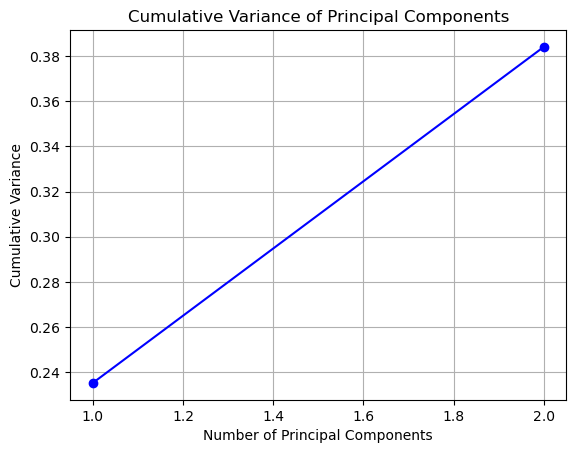

In [11]:
X_pca = apply_PCA(X, 2)

## Decision Tree

In [12]:
# Definir un espacio de búsqueda más amplio para la búsqueda de cuadrícula
param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None]
}

param_grid = {
    'max_depth': [None, 3, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 8, 12],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'class_weight': [None, 'balanced']
}


clf = DecisionTreeClassifier(class_weight='balanced', random_state=42)

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

## Random Forest

In [ ]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_samples': [None, 0.8, 0.9, 1.0],  # Solo para bootstrap=True
    'oob_score': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

0it [00:00, ?it/s]


Best parameters: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}

Mean Accuracy in cross-validation: 0.619241103848947
Standard Deviation of Accuracy in cross-validation: 0.06364876631487318


0it [00:00, ?it/s]

Best parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

Mean Accuracy in cross-validation: 0.6792588053740014
Standard Deviation of Accuracy in cross-validation: 0.06977601295264185


## SVM

In [ ]:
clf = SVC(class_weight='balanced', random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1e-3, 1e-4],
    'degree': [2, 3, 4],  # Solo para kernel 'poly'
    'coef0': [0.0, 0.1, 1.0]  # Solo para kernel 'poly' y 'sigmoid'
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

## Naive bayes

In [ ]:
# Crear el clasificador Naive Bayes
clf = GaussianNB()

# Definir el espacio de búsqueda
param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

Mejores parámetros: {'var_smoothing': 1.0}

Valor medio de Accuracy en cross validation: 0.4920915032679738
Desviación estándar de Accuracy en cross validation: 0.08005570932144956
Mejores parámetros: {'var_smoothing': 0.01}

Valor medio de Accuracy en cross validation: 0.5879831932773109
Desviación estándar de Accuracy en cross validation: 0.03683719056112774


## Perceptrón

In [ ]:
# Crear el clasificador Perceptrón Multicapa (MLP)
clf = MLPClassifier(random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0001]
}

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'max_iter': [100, 200, 300, 400, 500],
    'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'tol': [1e-4, 1e-3, 1e-2],
    'momentum': [0.9, 0.8, 0.7],
    'beta_1': [0.9, 0.8, 0.7],
    'beta_2': [0.999, 0.9, 0.8],
}


output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

Mejores parámetros: {'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'max_iter': 100}

Valor medio de Accuracy en cross validation: 0.605011219880256
Desviación estándar de Accuracy en cross validation: 0.1035173496998715
Mejores parámetros: {'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.1, 'max_iter': 100}

Valor medio de Accuracy en cross validation: 0.5417261957256666
Desviación estándar de Accuracy en cross validation: 0.09689920644807425


## XGBoost

In [ ]:
# Crear el clasificador XGBoost
clf = xgb.XGBClassifier(random_state=42)

# Definir el espacio de búsqueda
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 1, 10],
}


output = run_halving_grid_search(X, y, clf, param_grid)

output = run_halving_grid_search(X_pca, y, clf, param_grid)

KeyboardInterrupt: 

In [ ]:
len(features[0])

143

In [ ]:
'''
nombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'perímetros','circularidad', 'sum_im_bin', 'compacto', 'dissimilitude', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'std' ]
nombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'per', 'per/volume_blast', 'compacto', 'diss', 'cont', 'hom', 'en', 'corr', 'ASM', 'mean', 'std', 'lumen', 'diss2', 'cont2', 'hom2', 'en2', 'corr2', 'mean2', 'std2', 'lumen2']
def features_principales(best_model):
    
    feats_princ = []
    orden = np.flip(np.argsort(best_model.feature_importances_))
    #print(np.flip(np.sort(best_model.feature_importances_)))
    print(len(nombres))
    for i in range(len(orden)):
        feats_princ.append(nombres[orden[i]])
    return feats_princ

def features_values(best_model, names):
  vals = np.flip(np.sort(bestimator.feature_importances_))
  plt.figure(figsize=(10,5))
  ticks = np.arange(len(vals))
  labels = names
  plt.xticks(ticks, labels, rotation = 90)
  plt.bar(np.arange(len(vals)),vals)
'''

"\nnombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'perímetros','circularidad', 'sum_im_bin', 'compacto', 'dissimilitude', 'contrast', 'homogeneity', 'energy', 'correlation', 'ASM', 'mean', 'std' ]\nnombres =  ['size', 'volume_blast', 'radio_blast', 'volume_ICM', 'volume_blastocoel', 'ratio_vol_ICM', 'ratio_vol_blastoc', 'ratio_blastoc_ICM', 'per', 'per/volume_blast', 'compacto', 'diss', 'cont', 'hom', 'en', 'corr', 'ASM', 'mean', 'std', 'lumen', 'diss2', 'cont2', 'hom2', 'en2', 'corr2', 'mean2', 'std2', 'lumen2']\ndef features_principales(best_model):\n    \n    feats_princ = []\n    orden = np.flip(np.argsort(best_model.feature_importances_))\n    #print(np.flip(np.sort(best_model.feature_importances_)))\n    print(len(nombres))\n    for i in range(len(orden)):\n        feats_princ.append(nombres[orden[i]])\n    return feats_princ\n\ndef features_values(best_model, names):\n  vals = np.fl